In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import numpy.linalg as npl

import pherosensor

from pheromone_dispersion.advection_operator import Advection
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

In [2]:
Lx = 20
Ly = 25
Delta_x = 0.4
Delta_y = 0.4
T_final = 5.

# Test of the numerical scheme of the advection operator
This notebook aims to test the implementation of the numerical scheme of the advection operator.

The advection operator is the operator $A:c(x,y)\mapsto \nabla\cdot(U(x,y) c(x,y))~\forall (x,y)\in\Omega$ such that $U(x,y)c(x,y)\cdot \vec{n} = 0~\forall(x,y)\in\partial\Omega_i$ with $\partial\Omega_i = \{ (x,y)\in\partial\Omega, U(x,y)\cdot\vec{n}<0\}$.

## Reference solution

We consider the reference solution $c^{ref}(x,y) = sin\left(\frac{2\pi n_x}{L_x}x\right)sin\left(\frac{2\pi n_y}{L_y}y\right)$

In [3]:
nx = 5
ny = 7
lambda_x = 2 * np.pi * nx / Lx
lambda_y = 2 * np.pi * ny / Ly

def c_reference(x,y): 
    return np.sin(lambda_x * x) * np.sin(lambda_y * y)

and the velocity $U(x,y)=(u,v)(x,y)=(\frac{3}{L_x}x, \frac{4}{L_y}y)$.

In [4]:
def u(x):
    return 3*x/Lx

def v(y): 
    return 4*y/Ly    

def velocity_field(msh): 
    x, yi = np.meshgrid(msh.x, msh.y_horizontal_interface)
    U_hi = np.zeros((msh.y_horizontal_interface.size,msh.x.size,2))
    U_hi[:,:,0] = u(x)
    U_hi[:,:,1] = v(yi) 
    
    xi, y = np.meshgrid(msh.x_vertical_interface, msh.y)
    U_vi = np.zeros((msh.y.size,msh.x_vertical_interface.size,2))
    U_vi[:,:,0] = u(xi)
    U_vi[:,:,1] = v(y) 
    
    return Velocity(msh, U_vi, U_hi)

Therefore, we have:\
$\partial_x(uc^{ref})(x,y)=\frac{3}{L_x}\left(\frac{2\pi n_x}{L_x}xcos\left(\frac{2\pi n_x}{L_x}x\right)+sin\left(\frac{2\pi n_x}{L_x}x\right)\right)sin\left(\frac{2\pi n_y}{L_y}y\right)$,\
$\partial_y(vc^{ref})(x,y)=\frac{4}{L_y}\left(\frac{2\pi n_y}{L_y}ycos\left(\frac{2\pi n_y}{L_y}y\right)+sin\left(\frac{2\pi n_y}{L_y}y\right)\right)sin\left(\frac{2\pi n_x}{L_x}x\right)$.\
We can note that the reference solution satisfies the boundary conditions.

Hence, we have $Ac^{ref}(x,y) = \nabla\cdot(U c^{ref})(x,y) = \frac{3}{L_x}\left(\frac{2\pi n_x}{L_x}xcos\left(\frac{2\pi n_x}{L_x}x\right)+sin\left(\frac{2\pi n_x}{L_x}x\right)\right)sin\left(\frac{2\pi n_y}{L_y}y\right) + \frac{4}{L_y}\left(\frac{2\pi n_y}{L_y}ycos\left(\frac{2\pi n_y}{L_y}y\right)+sin\left(\frac{2\pi n_y}{L_y}y\right)\right)sin\left(\frac{2\pi n_x}{L_x}x\right)$

In [5]:
def Ac_reference(x,y): 
    res = (3 / Lx) * ( lambda_x * x * np.cos(lambda_x * x) + np.sin(lambda_x * x) ) * np.sin(lambda_y * y)
    res+= (4 / Ly) * ( lambda_y * y * np.cos(lambda_y * y) + np.sin(lambda_y * y) ) * np.sin(lambda_x * x)
    return res

## Numerical scheme

The numerical scheme used is a finite volume scheme. The average of the advection operator over a control volume $\Omega_{i,j}$ is : $\frac{1}{|\Omega_{i,j}|} \int_{\Omega_{i,j}} \nabla\cdot(U(x,y) c(x,y))dx dy = \frac{1}{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}U(x,y)c(x,y)\cdot \vec{n} dx dy$.\
In the present case, we use uniform cartesian meshes with the same space step along the two axis. We will denote by the indexes $i+\frac{1}{2},j$ the vertical interface between the control volumes $i,j$ and $i+1,j$, and similarly for the horizontal interfaces. Moreover, let us note that on the vertical interfaces $\vec{n}=(\pm1,0)$ and on the horizontal interfaces $\vec{n}=(0,\pm1)$.\
Therefore, we have: $\frac{1}{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}U(x,y)c(x,y)\cdot \vec{n} dx dy \approx A^{solver}c(x_i,y_j) = \frac{1}{|\Omega_{i,j}|}\left(\Delta y\left(c_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}-c_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\right)+\Delta x\left(c_{i,j+\frac{1}{2}}v_{i,j+\frac{1}{2}}-c_{i,j-\frac{1}{2}}v_{i,j-\frac{1}{2}}\right)\right)$.\
In the present case, the scheme is a upwind scheme. Therefore, the concentration at the interfaces are given by: 
- if $U_{i\pm1/2,j}\cdot \vec{n} = u_{i\pm1/2,j} > 0$, then $c_{i\pm1/2,j} = c_{i\pm1/2-1/2,j}$, else $c_{i\pm1/2,j} = c_{i\pm1/2+1/2,j}$,
- if $U_{i,j\pm1/2}\cdot \vec{n} = v_{i,j\pm1/2} > 0$, then $c_{i,j\pm1/2} = c_{i,j\pm1/2-1/2}$, else $c_{i,j\pm1/2} = c_{i,j\pm1/2+1/2}$.

In [6]:
space_factor_a = [0.005, 0.01, 0.1, 1.]
dx_a = np.zeros(len(space_factor_a))

MAE = np.zeros(len(space_factor_a))
RMSE = np.zeros(len(space_factor_a))

for i, space_factor in enumerate(space_factor_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x*space_factor, Delta_y*space_factor, T_final)
    x, y = np.meshgrid(msh.x, msh.y)
    dx_a[i] = Delta_x*space_factor
    
    c_ref = c_reference(x, y)
    Ac_ref = Ac_reference(x,y)

    U = velocity_field(msh)
    A = Advection(U, msh)
    Ac_solver = A.matvec(c_ref.reshape((msh.y.size * msh.x.size,)))
    Ac_solver = Ac_solver.reshape((msh.y.size, msh.x.size))
    
    RMSE[i] = npl.norm(Ac_solver - Ac_ref) / np.sqrt(Ac_ref.size)
    MAE[i] = np.mean(np.abs(Ac_solver-Ac_ref))
    
    print("")
    print("dx = ", msh.dx)


dx =  0.002

dx =  0.004

dx =  0.04000000000000001

dx =  0.4


## Analysis of the truncation error
In the present case, since the components of the velocity field are positive ($u,v\geq0$) and du to the uniform cartesian mesh (with $\Delta x = \Delta y$), the upwind finite volume scheme is equivalent to a standard upwind finite difference scheme.\
Hence, we have the truncation error $Rc(x,y) = |A^{solver}c(x,y) - A c(x,y)|=\mathcal{O}(\Delta x)$.

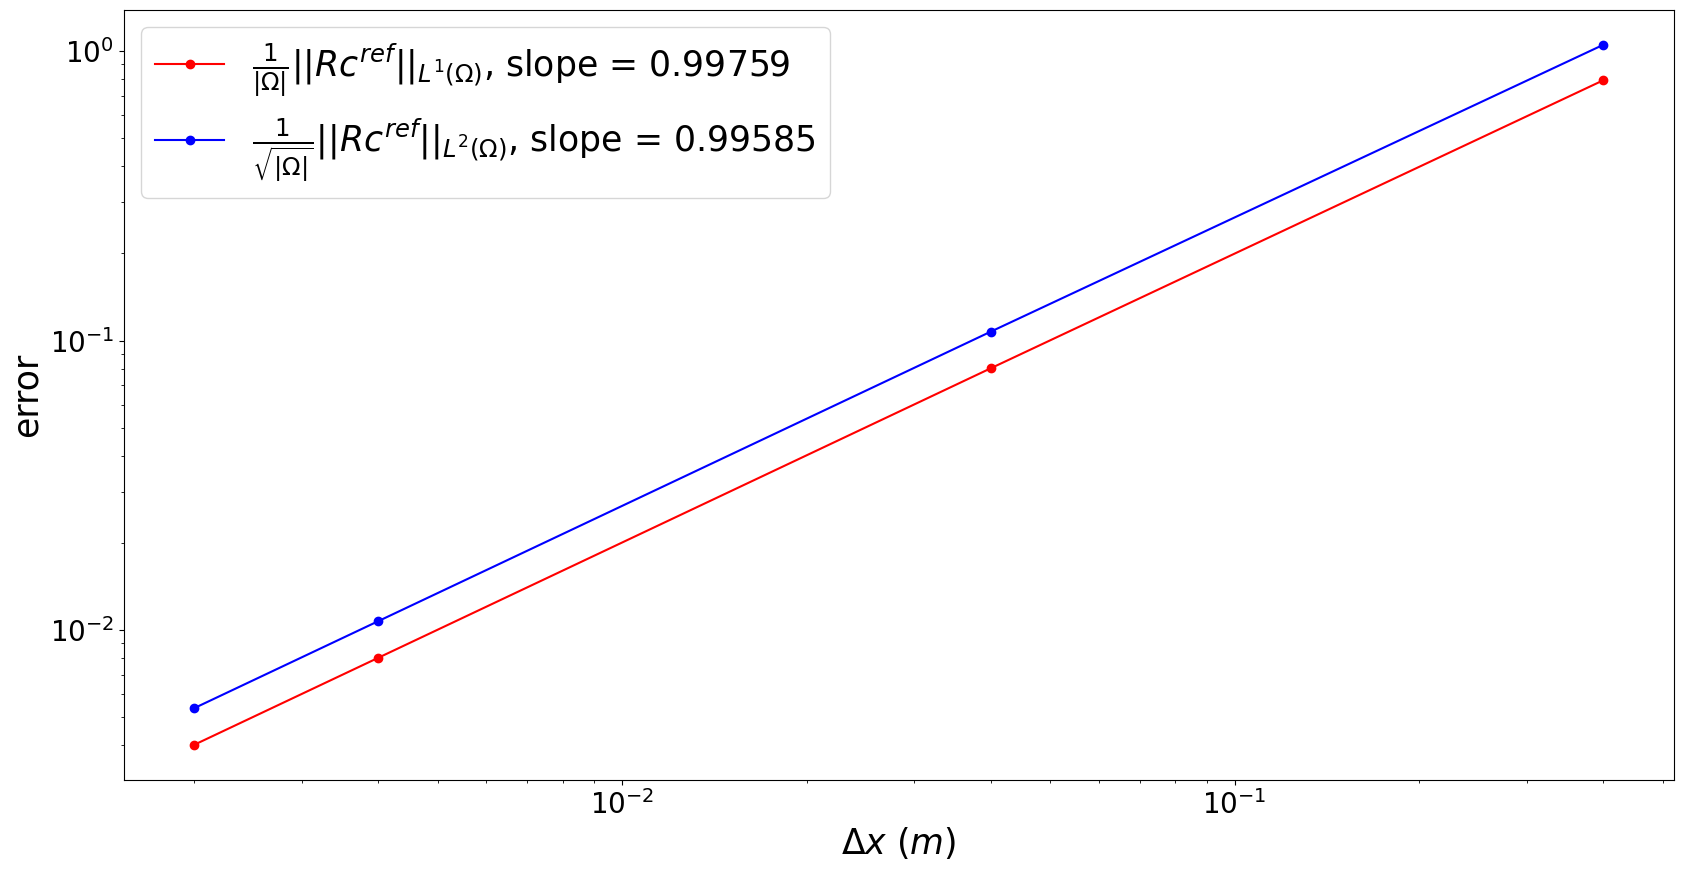

In [7]:
slope_MAE = (np.log(MAE[0]) - np.log(MAE[-1])) / (np.log(dx_a[0]) - np.log(dx_a[-1])) 
slope_RMSE = (np.log(RMSE[0]) - np.log(RMSE[-1]) ) / ( np.log(dx_a[0]) - np.log(dx_a[-1])) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(dx_a,MAE,'-or',label=r'$\frac{1}{|\Omega|}||Rc^{ref}||_{L^1(\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE)}')
ax1.plot(dx_a,RMSE,'-ob',label=r'$\frac{1}{\sqrt{|\Omega|}}||Rc^{ref}||_{L^2(\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE)}')
ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'error', fontsize=fontsize)
ax1.set_xlabel('$\Delta x$ ($m$)', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='upper left',prop={'size': fontsize})